<h1><font color="#113D68" size=5>TINTOlib: Converting Tidy Data into Synthetic Images</font></h1>

<h1><font color="#113D68" size=5>Template Classification Machine Learning problem with a CNN</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
<font color="#113D68" size=3>Raúl García-Castro</font><br>
<font color="#113D68" size=3>Jiayun Liu</font><br>

</div>

---

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
More information about [Manuel Castillo-Cara](https://www.manuelcastillo.eu/)

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
More information about [Raúl García-Castro](http://www.garcia-castro.com/)

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Licencia</font></h2>

<p><small><small>Improving Deep Learning by Exploiting Synthetic Images Copyright 2024 Manuel Castillo Cara.</p>
<p><small><small> Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at </p>
<p><small><small> <a href="https://www.apache.org/licenses/LICENSE-2.0">https://www.apache.org/licenses/LICENSE-2.0</a> </p>
<p><small><small> Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. </p>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Index</font></h2>

* [0. Context](#section0)
* [1. Description](#section1)
    * [1.1. Main Features](#section11)
    * [1.2. Citation](#section12)
    * [1.3. Documentation and License](#section13)
* [2. Libraries](#section2)
    * [2.1. System setup](#section21)
    * [2.2. Invoke the libraries](#section22)
* [3. Data processing](#section3)
    * [3.1. TINTOlib methods](#section31)
    * [3.2. Read the dataset](#section32)
    * [3.3. Generate images](#section33)
    * [3.4. Read images](#section34)
* [4. Pre-modelling phase](#section4)
    * [4.1. Data curation](#section41)
    * [4.2. Resize Images](#section42)
    * [4.3. Iterators](#section43)
* [5. Modelling with CNN](#section5)
    * [5.1. CNN](#section51)
    * [5.2. Compile and fit](#section52)
* [6. Results](#section6)
    * [6.1. Train/Validation representation](#section61)
    * [6.2. Validation/Test evaluation](#section62)
    * [6.3. Sklearn metrics evaluation](#section63)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

<a id="section2"></a>
# <font color="#004D7F" size=6> 2. Libraries</font>

The first thing we need to do is to declare the libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
#from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax, AdamW
from keras.layers import MaxPooling2D, AveragePooling2D, Activation, Input, Concatenate
from keras.utils import plot_model

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

/Users/manwest/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6> 3. Data processing</font>

---
<a id="section31"></a>
# <font color="#004D7F" size=5> 3.1. TINTOlib methods</font>

In [2]:
#Select the model and the parameters
problem_type = "supervised"
#problem_type = "regression"
pixelTML = 30
pixel = 20
## zoom para ampliar la imagen
#image_model = REFINED(problem=problem_type, random_seed=SEED, zoom=5, n_processors=8)
#image_model = TINTO(problem= problem_type, blur=True, option='maximum', pixels=pixel, random_seed=SEED)
# scale sería [7,4] porque hay 26 variables (para 24 pixeles); 
#image_model = IGTD(problem= problem_type, random_seed=SEED, scale=[3,3], zoom=5)
#image_model = BarGraph(problem= problem_type, pixel_width=2, gap=1, zoom=1)
#image_model = DistanceMatrix(problem= problem_type, zoom=4)
#image_model = Combination(problem= problem_type, zoom=3)
image_model = SuperTML(problem= problem_type, pixels = pixelTML, font_size=4, feature_importance=True, random_seed=SEED)
#image_model = SuperTML(problem= problem_type, pixels=pixel, font_size=4, random_seed=SEED)

#Define the dataset path and the folder where the images will be saved
results_folder = "SuperTML-FS"
dataset_path = "../dataset_train.csv"
images_folder = "SuperTML-FS"



<div class="alert alert-block alert-info">

<i class="fa fa-info-circle" aria-hidden="true"></i>
You can see all information about TINTOlib documentation in [PyPI](https://pypi.org/project/TINTOlib/)

---
<a id="section32"></a>
# <font color="#004D7F" size=5> 3.2. Read the dataset</font>

In [3]:
df=pd.read_csv(dataset_path)
df

,O3,TMP,RH,1/RH,WSP,WDR,class
0,163.000000,28.2,17.0,0.058824,3.2,346.0,1
1,170.000000,28.9,23.0,0.043478,3.4,355.0,1
2,181.000000,28.9,28.0,0.035714,4.4,345.0,1
3,171.000000,27.4,32.0,0.031250,4.7,357.0,1
4,124.000000,26.0,37.0,0.027027,5.2,355.0,1
...,...,...,...,...,...,...,...
23804,25.000000,21.3,90.0,0.011111,4.6,358.0,0
23805,23.000000,20.6,89.0,0.011236,4.5,343.0,0
23806,21.285714,19.1,91.0,0.010989,3.9,359.0,0
23807,16.000000,18.9,91.0,0.010989,3.6,356.0,0


In [4]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


---
<a id="section33"></a>
# <font color="#004D7F" size=5> 3.3. Generate images</font>

In [5]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.generateImages(df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

SuperTML-FS/supervised.csv


<a id="section34"></a>
# <font color="#004D7F" size=5> 3.4. Read images</font>

Once the images have been created we can read them. In this particular case, by using a pure CNN, we will use the images only to train our model.

In [6]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]
imgs = imgs.rename(columns={"class":"values"})
imgs

,images,values
0,SuperTML-FS/01/000000.png,1
1,SuperTML-FS/01/000001.png,1
2,SuperTML-FS/01/000002.png,1
3,SuperTML-FS/01/000003.png,1
4,SuperTML-FS/01/000004.png,1
...,...,...
23804,SuperTML-FS/00/023804.png,0
23805,SuperTML-FS/00/023805.png,0
23806,SuperTML-FS/00/023806.png,0
23807,SuperTML-FS/00/023807.png,0


---
<a id="section35"></a>
# <font color="#004D7F" size=5> 3.5. Mix images and tidy data</font>

If we want to use hybrid networks, i.e. create a model in which we join a CNN for the images and a MLP for the tabular data, we need to join it in order to integrate all the data in our hybrid model.


Combine the images and tidy data in the same dataframe, split attributes and objective value

In [7]:
combined_dataset = pd.concat([imgs,df],axis=1)
# Drop target column and values which is a copy of target column
df_x = combined_dataset.drop(df.columns[-1],axis=1).drop("values",axis=1)
df_y = combined_dataset["values"]

df_x

,images,O3,TMP,RH,1/RH,WSP,WDR
0,SuperTML-FS/01/000000.png,163.000000,28.2,17.0,0.058824,3.2,346.0
1,SuperTML-FS/01/000001.png,170.000000,28.9,23.0,0.043478,3.4,355.0
2,SuperTML-FS/01/000002.png,181.000000,28.9,28.0,0.035714,4.4,345.0
3,SuperTML-FS/01/000003.png,171.000000,27.4,32.0,0.031250,4.7,357.0
4,SuperTML-FS/01/000004.png,124.000000,26.0,37.0,0.027027,5.2,355.0
...,...,...,...,...,...,...,...
23804,SuperTML-FS/00/023804.png,25.000000,21.3,90.0,0.011111,4.6,358.0
23805,SuperTML-FS/00/023805.png,23.000000,20.6,89.0,0.011236,4.5,343.0
23806,SuperTML-FS/00/023806.png,21.285714,19.1,91.0,0.010989,3.9,359.0
23807,SuperTML-FS/00/023807.png,16.000000,18.9,91.0,0.010989,3.6,356.0


In [8]:
combined_dataset

,images,values,O3,TMP,RH,1/RH,WSP,WDR,class
0,SuperTML-FS/01/000000.png,1,163.000000,28.2,17.0,0.058824,3.2,346.0,1
1,SuperTML-FS/01/000001.png,1,170.000000,28.9,23.0,0.043478,3.4,355.0,1
2,SuperTML-FS/01/000002.png,1,181.000000,28.9,28.0,0.035714,4.4,345.0,1
3,SuperTML-FS/01/000003.png,1,171.000000,27.4,32.0,0.031250,4.7,357.0,1
4,SuperTML-FS/01/000004.png,1,124.000000,26.0,37.0,0.027027,5.2,355.0,1
...,...,...,...,...,...,...,...,...,...
23804,SuperTML-FS/00/023804.png,0,25.000000,21.3,90.0,0.011111,4.6,358.0,0
23805,SuperTML-FS/00/023805.png,0,23.000000,20.6,89.0,0.011236,4.5,343.0,0
23806,SuperTML-FS/00/023806.png,0,21.285714,19.1,91.0,0.010989,3.9,359.0,0
23807,SuperTML-FS/00/023807.png,0,16.000000,18.9,91.0,0.010989,3.6,356.0,0


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6> 4. Pre-modelling phase</font>

Once the data is ready, we load it into memory with an iterator in order to pass it to the CNN.

---
<a id="section41"></a>
# <font color="#004D7F" size=5> 4.1. Data curation</font>

Split in train/test/validation

In [9]:
import cv2
from sklearn.preprocessing import MinMaxScaler
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size = 0.30, random_state=SEED,stratify=df_y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state=SEED,stratify=y_val)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
"""X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])"""

# For 1 channels (GRAY SCALE)
X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
height, width = X_train_img[0].shape
channels=1
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (30, 30, 1)
Attributres:  6
Image size (pixels): 30


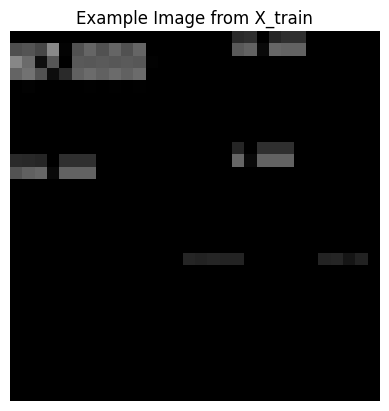

In [10]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[0]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

In our case, as we are going to train with a pre-trained network, we must resize it to the dimensions established by the network. Therefore, if you make a customised CNN, this cell is optional. 

In [11]:
X_train_img = X_train_img/255
X_val_img = X_val_img/255
X_test_img = X_test_img/255

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section5"></a>
# <font color="#004D7F" size=6> 5. Modelling with CNN</font>

<a id="section51"></a>
# <font color="#004D7F" size=5> 5.1. CNN</font>

In [12]:
dropout = 0.2
epochs = 100
n_class = df['class'].value_counts().count()
n_class

2

<div class="alert alert-block alert-info">

<i class="fa fa-info-circle" aria-hidden="true"></i>
💡 **Important**: `padding="same"` is very important to avoid losing the first/last row/column of pixels. Keep in mind that the images have a small size.


In [13]:
#Entrada
input_shape = Input(shape=(pixel, pixel,1))
        
#Inicio de rama 1
tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape)
#tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
#tower_1 = Dropout(dropout)(tower_1)
        
tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
#tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
#tower_1 = Dropout(dropout)(tower_1)
        
tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
#tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
#tower_1 = Dropout(dropout)(tower_1)
        
#tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
#tower_1 = BatchNormalization()(tower_1)
#tower_1 = Activation('relu')(tower_1)
#tower_1 = MaxPooling2D(2,2)(tower_1)
#tower_1 = Dropout(dropout)(tower_1)
#Fin de rama 1
        
#Inicio de rama 2
tower_2 = Conv2D(16, (5,5), activation='relu',padding="same")(input_shape)
#tower_2 = BatchNormalization()(tower_2)
#tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
#tower_2 = Dropout(dropout)(tower_2)
        
tower_2 = Conv2D(32, (5,5), activation='relu',padding="same")(tower_2)
#tower_2 = BatchNormalization()(tower_2)
#tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
#tower_2 = Dropout(dropout)(tower_2)
        
tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
#tower_2 = BatchNormalization()(tower_2)
#tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
#tower_2 = Dropout(dropout)(tower_2)
        
#tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
#tower_2 = BatchNormalization()(tower_2)
#tower_2 = Activation('relu')(tower_2)
#tower_2 = AveragePooling2D(2,2)(tower_2)
#tower_2 = Dropout(dropout)(tower_2)
            
#Concatenación de las 2 ramas
merged = Concatenate(axis=1)([tower_1, tower_2])
        
#Aplanamiento
merged = Flatten()(merged)
        
#Capas adicionales
#out = Dense(512, activation='relu')(merged)
#out = Dense(256, activation='relu')(merged)
out = Dense(128, activation='relu')(merged)
out = Dense(64, activation='relu')(out)
out = Dense(32, activation='relu')(out)
        
#Capa final de clasificación
#out = Dense(n_class, activation='softmax')(out)
out = Dense(1, activation='sigmoid')(out)
        
model = Model(input_shape, out)

2024-12-13 09:33:07.566066: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-13 09:33:07.566109: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-13 09:33:07.566122: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-13 09:33:07.566148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-13 09:33:07.566177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
METRICS = [
      tf.keras.metrics.TruePositives(name = 'tp'),
      tf.keras.metrics.FalsePositives(name = 'fp'),
      tf.keras.metrics.TrueNegatives(name = 'tn'),
      tf.keras.metrics.FalseNegatives(name = 'fn'), 
      tf.keras.metrics.BinaryAccuracy(name ='accuracy'),
      tf.keras.metrics.Precision(name = 'precision'),
      tf.keras.metrics.Recall(name = 'recall'),
      tf.keras.metrics.AUC(name = 'auc'),
]

<a id="section52"></a>
# <font color="#004D7F" size=5> 5.2. Compile and fit</font>

Note to **specify the loss** depending on whether you have a binary or multiclass classification problem.

In [15]:
opt = Adamax()
#Adam(learning_rate=1e-6)
model.compile(
                #optimizer = sgd,
                optimizer = opt,
                #optimizer = 'Adadelta',
                #optimizer = 'Adamax',
                #optimizer = opt,
                metrics = METRICS,
                #metrics = ['accuracy'],
                
                loss = 'binary_crossentropy'
                #loss = 'categorical_crossentropy'
                )

In [16]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [17]:
modelfitprogress = model.fit(
                              x=[X_train_img], y=y_train,
                              validation_data=([X_val_img], y_val),
                              epochs = epochs,
                              callbacks = [early_stopper]
                              #steps_per_epoch = df_train.shape[0]//train_iter.batch_size,
                              #validation_steps = df_val.shape[0]//valid_iter.batch_size
                              )

Epoch 1/100


/Users/manwest/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=('*',)
  warnings.warn(
2024-12-13 09:33:08.674556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


521/521 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9236 - auc: 0.5192 - fn: 647.7931 - fp: 0.0000e+00 - loss: 0.3000 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 7720.1226 - tp: 0.0000e+00 - val_accuracy: 0.9238 - val_auc: 0.6281 - val_fn: 272.0000 - val_fp: 0.0000e+00 - val_loss: 0.2596 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 3299.0000 - val_tp: 0.0000e+00
Epoch 2/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9236 - auc: 0.5943 - fn: 647.7931 - fp: 0.0000e+00 - loss: 0.2602 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 7720.1226 - tp: 0.0000e+00 - val_accuracy: 0.9238 - val_auc: 0.7014 - val_fn: 272.0000 - val_fp: 0.0000e+00 - val_loss: 0.2521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 3299.0000 - val_tp: 0.0000e+00
Epoch 3/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9236 - auc: 0.6536 - fn: 647.7931 - fp: 0.0000e+00 - loss: 0.2550 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 7720.1226 - 

<a id="section6"></a>
# <font color="#004D7F" size=6> 6. Results</font>

---
<a id="section61"></a>
# <font color="#004D7F" size=5> 6.1. Train/Validation representation</font>

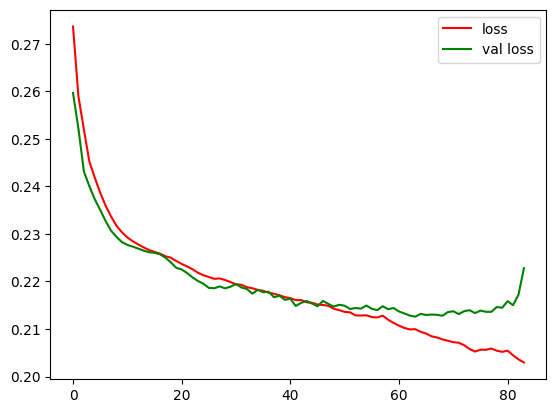

In [18]:
plt.plot(modelfitprogress.history['loss'], color = 'red', label = 'loss')
plt.plot(modelfitprogress.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')
#plt.ylim(0,1)
plt.show()

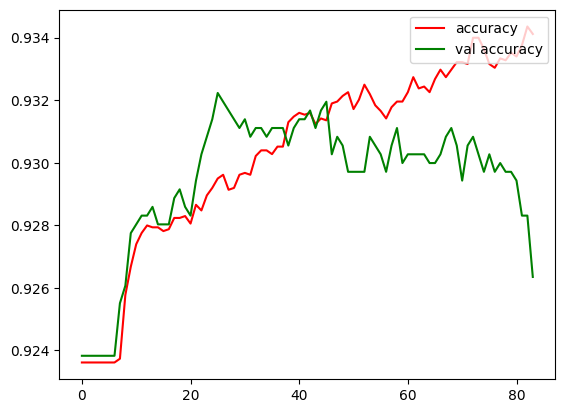

In [19]:
plt.plot(modelfitprogress.history['accuracy'], color = 'red', label = 'accuracy')
plt.plot(modelfitprogress.history['val_accuracy'], color = 'green', label = 'val accuracy')
plt.legend(loc = 'upper right')

plt.show()

In [20]:
train_accuracy = modelfitprogress.history["accuracy"][-1]
train_auc = modelfitprogress.history["auc"][-1]
train_precision = modelfitprogress.history["precision"][-1]
train_recall = modelfitprogress.history["recall"][-1]
train_loss = modelfitprogress.history["loss"][-1]

print("Train accuracy:",train_accuracy)
print("Train AUC:",train_auc)
print("Train precision:",train_precision)
print("Train recall:",train_recall)
print("Train loss:",train_loss)

Train accuracy: 0.9341173768043518
Train AUC: 0.8312336206436157
Train precision: 0.7692307829856873
Train recall: 0.19638648629188538
Train loss: 0.20295803248882294


In [21]:
validation_accuracy = modelfitprogress.history["val_accuracy"][-1]
validation_auc = modelfitprogress.history["val_auc"][-1]
validation_precision = modelfitprogress.history["val_precision"][-1]
validation_recall = modelfitprogress.history["val_recall"][-1]
validation_loss = modelfitprogress.history["val_loss"][-1]

print("Validation accuracy:",validation_accuracy)
print("Validation AUC:",validation_auc)
print("Validation precision:",validation_precision)
print("Validation recall:",validation_recall)
print("Validation loss:",validation_loss)

Validation accuracy: 0.9263511896133423
Validation AUC: 0.8088390827178955
Validation precision: 0.5445544719696045
Validation recall: 0.20220588147640228
Validation loss: 0.22279377281665802


---
<a id="section62"></a>
# <font color="#004D7F" size=5> 6.2. Validation evaluation</font>

Encontrar el mejor corte de probabilidades

In [22]:
from sklearn.metrics import roc_auc_score
x_train_1 = [X_train_img]

def find_best_threshold(y_true, y_probs):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_auc = 0
    best_thresh = 0
    for thresh in thresholds:
        preds = (y_probs >= thresh).astype(int)
        auc = roc_auc_score(y_true, preds)
        if auc > best_auc:
            best_auc = auc
            best_thresh = thresh
    return best_thresh, best_auc
prediction = model.predict(x_train_1,)
best_threshold = find_best_threshold(y_train, prediction)
best_threshold ### !!!!!! IMPORTANTE PARA DEFINIR EL MEJOR CORTE PARA LAS PROBABILIDADES

521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(0.08, 0.7307863895245434)

In [23]:
#x_validacion = [X_test_num, X_test_img]
#y_validacion = y_test
#x_validacion = valid_iter
#y_validacion = y_val
score_test= model.evaluate([X_val_img], y_val)
print("Loss in validation: {} \nAccuracy in validation: {}".format(score_test[0], score_test[5]))

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9262 - auc: 0.8326 - fn: 118.0796 - fp: 11.1150 - loss: 0.2161 - precision: 0.7058 - recall: 0.1547 - tn: 1669.8761 - tp: 24.4159
Loss in validation: 0.21259188652038574 
Accuracy in validation: 0.9302716255187988


In [24]:
#test_images = next(test_iter)[0]
prediction = model.predict([X_val_img])
#prediction = model.predict(test_images)
prediction_labels = (prediction > best_threshold[0]).astype(int)
#print(prediction_labels)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [25]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score

test_accuracy = score_test[5]
test_auc = score_test[8]
test_precision = score_test[6]
test_recall = score_test[7]

print("Validation accuracy:",test_accuracy)
print("Validation AUC:",test_auc)
print("Validation precision:",test_precision)
print("Validation recall:",test_recall)

Validation accuracy: 0.9302716255187988
Validation AUC: 0.8145962357521057
Validation precision: 0.6619718074798584
Validation recall: 0.17279411852359772


In [26]:
y_test1 = y_val.astype(float).astype(int)
y_test1

19630    0
11186    0
8758     0
4616     0
16735    0
        ..
2079     0
17000    0
10190    0
7585     0
7246     0
Name: values, Length: 3571, dtype: int64

Test Dataset. 


Confusion matrix:


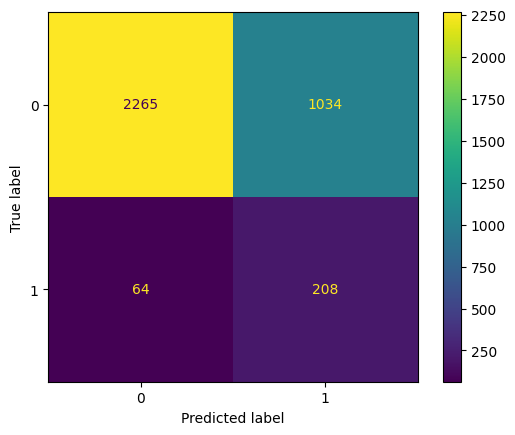

Verdaderos Negativos (VN): 2265
Falsos Positivos (FP): 1034
Falsos Negativos (FN): 64
Verdaderos Positivos (VP): 208 


AUC SCORE:
0.8151668063406023
Recall SCORE:
0.7647058823529411


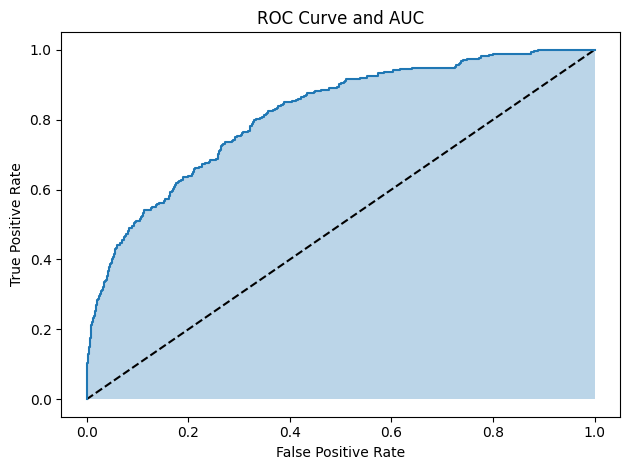

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, recall_score

# Suponiendo que ⁠ cnn_model ⁠ sea tu modelo entrenado y ⁠ X_test ⁠ tu conjunto de prueba
print("\033[1mTest Dataset.\033[0m \n\n")

# Confusion Matrix
print("\033[1mConfusion matrix:\033[0m")
cm = confusion_matrix(y_test1, prediction_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f"Verdaderos Negativos (VN): {cm[0, 0]}")
print(f"Falsos Positivos (FP): {cm[0, 1]}")
print(f"Falsos Negativos (FN): {cm[1, 0]}")
print(f"Verdaderos Positivos (VP): {cm[1, 1]} \n\n")

# Calcular las métricas usando probabilidades en lugar de etiquetas
#prediction_probs = model.predict([X_val_img])

print("\033[1mAUC SCORE:\033[0m")
print(roc_auc_score(y_test1, prediction ))

print("\033[1mRecall SCORE:\033[0m")
print(recall_score(y_test1, prediction_labels))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test1, prediction)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and AUC')
plt.fill_between(fpr, tpr, alpha=0.3)
plt.tight_layout()
plt.show()

---
<a id="section62"></a>
# <font color="#004D7F" size=5> 6.2. Test evaluation</font>

In [28]:
#x_validacion = [X_test_num, X_test_img]
#y_validacion = y_test
#x_validacion = test_iter
#y_validacion = y_test
score_test= model.evaluate([X_test_img], y_test)
print("Loss in Test: {} \nAccuracy in Test: {}".format(score_test[0], score_test[5]))

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9274 - auc: 0.7968 - fn: 121.0443 - fp: 10.6991 - loss: 0.2234 - precision: 0.6452 - recall: 0.1557 - tn: 1670.7965 - tp: 20.9646
Loss in Test: 0.22167102992534637 
Accuracy in Test: 0.9291713237762451


In [29]:
#test_images = next(test_iter)[0]
prediction = model.predict([X_test_img])
#prediction = model.predict(test_images)
prediction_labels = (prediction > best_threshold[0]).astype(int)
#print(prediction_labels)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [30]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score

test_accuracy = score_test[5]
test_auc = score_test[8]
test_precision = score_test[6]
test_recall = score_test[7]

print("Test accuracy:",test_accuracy)
print("Test AUC:",test_auc)
print("Test precision:",test_precision)
print("Test recall:",test_recall)

Test accuracy: 0.9291713237762451
Test AUC: 0.7900062799453735
Test precision: 0.6666666865348816
Test recall: 0.14652015268802643


In [31]:
y_test1 = y_test.astype(float).astype(int)
y_test1

650      1
4910     0
20672    0
973      1
12541    0
        ..
17306    0
4503     0
3256     0
8932     0
21240    0
Name: values, Length: 3572, dtype: int64

Test Dataset. 


Confusion matrix:


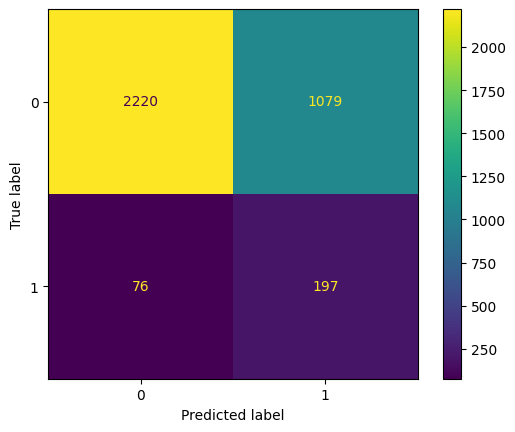

Verdaderos Negativos (VN): 2220
Falsos Positivos (FP): 1079
Falsos Negativos (FN): 76
Verdaderos Positivos (VP): 197 


AUC SCORE:
0.7905137198862571
Recall SCORE:
0.7216117216117216


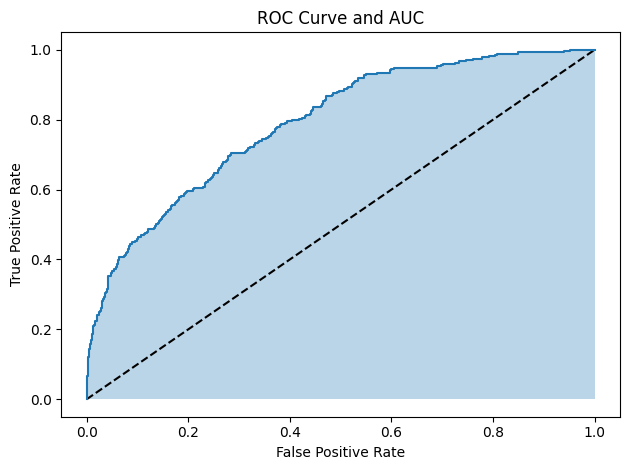

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, recall_score

# Suponiendo que ⁠ cnn_model ⁠ sea tu modelo entrenado y ⁠ X_test ⁠ tu conjunto de prueba
print("\033[1mTest Dataset.\033[0m \n\n")

# Confusion Matrix
print("\033[1mConfusion matrix:\033[0m")
cm = confusion_matrix(y_test1, prediction_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f"Verdaderos Negativos (VN): {cm[0, 0]}")
print(f"Falsos Positivos (FP): {cm[0, 1]}")
print(f"Falsos Negativos (FN): {cm[1, 0]}")
print(f"Verdaderos Positivos (VP): {cm[1, 1]} \n\n")

# Calcular las métricas usando probabilidades en lugar de etiquetas
#prediction_probs = model.predict([X_val_img])

print("\033[1mAUC SCORE:\033[0m")
print(roc_auc_score(y_test1, prediction ))

print("\033[1mRecall SCORE:\033[0m")
print(recall_score(y_test1, prediction_labels))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test1, prediction)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve and AUC')
plt.fill_between(fpr, tpr, alpha=0.3)
plt.tight_layout()
plt.show()